### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_East_Melanesian_Islands/Cleaned_Islands_CLEANED"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]12:26:56 Initiating the NLP Engine
[INFO]12:26:56 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_East_Melanesian_Islands/Cleaned_Islands_CLEANED.txt is being ported to dataframe
[INFO]12:26:56 /home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_East_Melanesian_Islands/Cleaned_Islands_CLEANED.txt has been ported to dataframe
[INFO]12:26:56 Trimming data and preparing list of words
[["'Variation in human skin pigmentation evolved in response to the selective pressure of ultra-violet radiation (UVR). Selection to maintain darker skin in high UVR environments is expected to constrain pigmentation phenotype and variation in pigmentation loci. Consistent with this hypothesis, the gene MC1R exhibits reduced diversity in African populations from high UVR regions compared to low-UVR non-African populations. However, MC1R diversity in non-African populations that have evolved under high-UVR conditions is not well characterized. '"], ["'The Cicadoidea fauna of Wallacea, New G

[INFO]12:26:56 Generating bigrams
[INFO]12:26:56 Generating word bigrams
[INFO]12:26:56 Generated word bigrams
[INFO]12:26:57 Beginning lemmatization
[INFO]12:26:59 Ending lemmatization
[INFO]12:27:1 Issued perplexity: -9.314273562037751
[INFO]12:27:1 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.020*"absence" + 0.012*"melt" + 0.011*"genera" + 0.010*"indo" + 0.008*"zircon" + 0.008*"law" + 0.007*"tropic" + 0.007*"provision" + 0.007*"dry" + 0.006*"description"'),
 (1,
  '0.011*"social" + 0.010*"community" + 0.008*"system" + 0.008*"develop" + 0.007*"base" + 0.007*"global" + 0.007*"paper" + 0.007*"country" + 0.006*"church" + 0.006*"article"'),
 (2,
  '0.030*"measure" + 0.024*"strain" + 0.023*"core" + 0.017*"dependent" + 0.010*"programme" + 0.009*"vector" + 0.007*"fallout" + 0.007*"goal" + 0.006*"sometimes" + 0.006*"bay"'),
 (3,
  '0.014*"model" + 0.013*"trade" + 0.010*"pattern" + 0.010*"effect" + 0.009*"island" + 0.009*"datum" + 0.008*"include" + 0.007*"period" + 0.007*"recent" + 0.007*"structure"'),
 (4,
  '0.034*"forest" + 0.020*"biodiversity" + 0.017*"conservation" + 0.015*"specifically" + 0.015*"quantitative" + 0.012*"fragmentation" + 0.010*"bone" + 0.009*"identity" + 0.009*"head" + 0.009*"island"'),
 (5,
  '0.016*"region" + 0.013*"ground" + 0.012*"expression" + 0.010

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(3,
  [('island', 0.08215624099164025),
   ('datum', 0.021908330931104066),
   ('suggest', 0.019313923320841742),
   ('evidence', 0.01902565580859037),
   ('history', 0.01671951571057942),
   ('recent', 0.014413375612568464),
   ('origin', 0.013548573075814356),
   ('early', 0.013548573075814356),
   ('archaeological', 0.012107235514557509),
   ('propose', 0.012107235514557509)]),
 (8,
  [('basin', 0.021597710122300287),
   ('zone', 0.013010668748373666),
   ('rock', 0.011189175123601354),
   ('range', 0.01092896174863388),
   ('east', 0.010668748373666407),
   ('plate', 0.010668748373666407),
   ('volcanic', 0.010408534998698933),
   ('form', 0.01014832162373146),
   ('subduction', 0.009888108248763986),
   ('ridge', 0.009627894873796514)]),
 (6,
  [('paper', 0.021357519016968987),
   ('approach', 0.01609128145114102),
   ('process', 0.01579871269748391),
   ('development', 0.014628437682855471),
   ('state', 0.013750731421884143),
   ('examine', 0.013750731421884143),
   ('trade', 0

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.38600442039170585


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

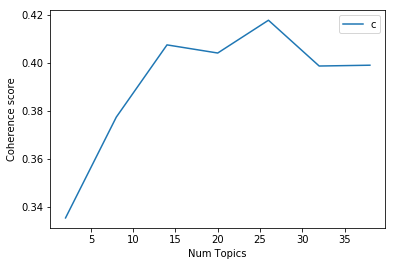

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)
print(model_topics)

[(4, [('region', 0.042364532019704436), ('level', 0.022660098522167486), ('group', 0.020361247947454843), ('present', 0.019704433497536946), ('forest', 0.015763546798029555), ('identify', 0.015106732348111659), ('australia', 0.01444991789819376), ('analysis', 0.01444991789819376), ('pattern', 0.013793103448275862), ('number', 0.012151067323481117)]), (7, [('model', 0.03626265926167919), ('result', 0.026461940542306436), ('datum', 0.021561581182620058), ('current', 0.017641293694870958), ('structure', 0.015354459327017315), ('flow', 0.015027768703038223), ('time', 0.013394315583142764), ('deep', 0.012414243711205489), ('base', 0.010780790591310029), ('pattern', 0.010780790591310029)]), (0, [('pacific', 0.06805229634596044), ('eastern', 0.021119678176332552), ('area', 0.020449212202480724), ('ocean', 0.020449212202480724), ('show', 0.019778746228628897), ('change', 0.01910828025477707), ('western', 0.018773047267851155), ('central', 0.016426416359369762), ('water', 0.01609118337244385), 

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.068*"pacific" + 0.021*"eastern" + 0.020*"ocean" + 0.020*"area" + '
  '0.020*"show" + 0.019*"change" + 0.019*"western" + 0.016*"central" + '
  '0.016*"sea" + 0.016*"water" + 0.016*"part" + 0.015*"source" + 0.013*"land" '
  '+ 0.012*"effect" + 0.012*"distribution" + 0.011*"follow" + 0.011*"region" + '
  '0.010*"remain" + 0.010*"environmental" + 0.009*"oceanic" + 0.009*"field" + '
  '0.009*"reflect" + 0.009*"determine" + 0.008*"indian" + 0.007*"surface" + '
  '0.007*"map" + 0.007*"variable" + 0.006*"site" + 0.006*"local" + '
  '0.006*"explain" + 0.006*"west" + 0.006*"characteristic" + 0.006*"sediment" '
  '+ 0.006*"shift" + 0.005*"global" + 0.005*"relative" + 0.005*"indian_ocean" '
  '+ 0.005*"atlantic" + 0.005*"close" + 0.005*"couple"'),
 (1,
  '0.021*"difference" + 0.020*"disease" + 0.019*"high" + 0.016*"prevalence" + '
  '0.015*"year" + 0.014*"rate" + 0.013*"significant" + 0.013*"level" + '
  '0.013*"increase" + 0.012*"activity" + 0.012*"age" + 0.012*"association" + '
  '0.01

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.3172,"population, genetic, frequency, individual, ty...",['Variation in human skin pigmentation evolved...
1,1,4.0,0.2604,"region, level, group, present, forest, identif...","['The Cicadoidea fauna of Wallacea, New Guinea..."
2,2,0.0,0.3512,"pacific, eastern, area, ocean, show, change, w...",['The anthropogenic plutonium isotopes are imp...
3,3,3.0,0.2556,"island, datum, suggest, evidence, history, rec...",['The Malayo-Oceanic tropics have long been re...
4,4,7.0,0.7003,"model, result, datum, current, structure, flow...",['We conducted 1-year-long mooring observation...
5,5,11.0,0.6318,"natural, base, potential, traditional, system,...",['Laboratory and field investigations were car...
6,6,2.0,0.3923,"htlv, associate, system, cell, melanesian, des...",['It is the contention of this paper that some...
7,7,3.0,0.2686,"island, datum, suggest, evidence, history, rec...","[The Pacific Islands or Oceania, typically sub..."
8,8,1.0,0.5867,"difference, disease, high, prevalence, year, r...",['The study of different ethnic groups living ...
9,9,8.0,0.4983,"basin, zone, rock, range, east, plate, volcani...","['Swath bathymetric, sonar imagery and seismic..."


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"population, genetic, frequency, individual, ty...",80.0,0.1501
1,4.0,"region, level, group, present, forest, identif...",40.0,0.0750
2,0.0,"pacific, eastern, area, ocean, show, change, w...",33.0,0.0619
3,3.0,"island, datum, suggest, evidence, history, rec...",49.0,0.0919
4,7.0,"model, result, datum, current, structure, flow...",32.0,0.0600
5,11.0,"natural, base, potential, traditional, system,...",54.0,0.1013
6,2.0,"htlv, associate, system, cell, melanesian, des...",57.0,0.1069
7,3.0,"island, datum, suggest, evidence, history, rec...",19.0,0.0356
8,1.0,"difference, disease, high, prevalence, year, r...",62.0,0.1163
9,8.0,"basin, zone, rock, range, east, plate, volcani...",54.0,0.1013


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      22.162788        1       1 -0.196400 -0.260692
8      17.093506        1       2 -0.211580  0.201142
9      16.876577        1       3 -0.135999  0.103543
3      16.776003        1       4 -0.178721  0.007950
5      10.172461        1       5 -0.113658 -0.039875
7       5.129719        1       6  0.012160 -0.014673
10      2.934413        1       7  0.162553  0.070661
4       2.633334        1       8  0.125661 -0.022243
11      2.622982        1       9  0.139861 -0.006391
6       2.045508        1      10  0.136868 -0.024963
0       0.968762        1      11  0.129804 -0.007091
2       0.583947        1      12  0.129451 -0.007367, topic_info=     Category        Freq             Term       Total  loglift  logprob
1245  Default  335.000000       population  335.000000  30.0000  30.0000
4568  Default   66.000000             htlv   66.000000  29.0000  29.0000
3474  Default  129.000000          genetic  129.000000  28.0000  28.0000
4918  Default   92.000000            trade   92.000000  27.0000  27.0000
3770  Default  171.000000           region  171.000000  26.0000  26.0000
327   Default   87.000000             cell   87.000000  25.0000  25.0000
766   Default   37.000000           forest   37.000000  24.0000  24.0000
6972  Default  159.000000           island  159.000000  23.0000  23.0000
5998  Default   44.000000         resource   44.000000  22.0000  22.0000
182   Default   93.000000             area   93.000000  21.0000  21.0000
6059  Default  130.000000             type  130.000000  20.0000  20.0000
3273  Default  102.000000           social  102.000000  19.0000  19.0000
46    Default   76.000000             gene   76.000000  18.0000  18.0000
2330  Default  168.000000            model  168.000000  17.0000  17.0000
286   Default   57.000000           ground   57.000000  16.0000  16.0000
6578  Default   68.000000          patient   68.000000  15.0000  15.0000
2775  Default   37.000000              man   37.000000  14.0000  14.0000
2103  Default   77.000000             zone   77.000000  13.0000  13.0000
5632  Default   71.000000        frequency   71.000000  12.0000  12.0000
4175  Default   48.000000       expression   48.000000  11.0000  11.0000
6535  Default   95.000000        community   95.000000  10.0000  10.0000
6600  Default   48.000000     relationship   48.000000   9.0000   9.0000
3687  Default   63.000000            basin   63.000000   8.0000   8.0000
2661  Default   49.000000            field   49.000000   7.0000   7.0000
4125  Default   62.000000            index   62.000000   6.0000   6.0000
2774  Default   54.000000           factor   54.000000   5.0000   5.0000
5619  Default  103.000000         evidence  103.000000   4.0000   4.0000
5339  Default   36.000000         genotype   36.000000   3.0000   3.0000
7006  Default   59.000000          surface   59.000000   2.0000   2.0000
6031  Default   51.000000             site   51.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
2567  Topic12    1.568885             goal    2.356408   4.7363  -5.0279
6171  Topic12    1.488240        sometimes    2.275747   4.7184  -5.0807
5388  Topic12    1.440184              bay    2.227674   4.7069  -5.1135
1483  Topic12    1.297042             belt    2.084522   4.6687  -5.2182
6412  Topic12    1.181599              ppg    1.969083   4.6324  -5.3114
16    Topic12    1.151946      elimination    1.939418   4.6222  -5.3369
469   Topic12    1.130189             atom    1.917660   4.6144  -5.3559
5301  Topic12    1.054701     intervention    1.842191   4.5854  -5.4251
5514  Topic12    0.890179               pu    1.677708   4.5094  -5.5946
5630  Topic12    0.881560         residual    1.669044   4.5048  -5.6044
3614  Topic12    0.655959         constant    1.444241   4.3539  -5.9000
7107  Topic12    0.646372            march    1.433877   4.346

In [38]:
topics = optimal_model.show_topics(num_topics = -1, formatted=False)

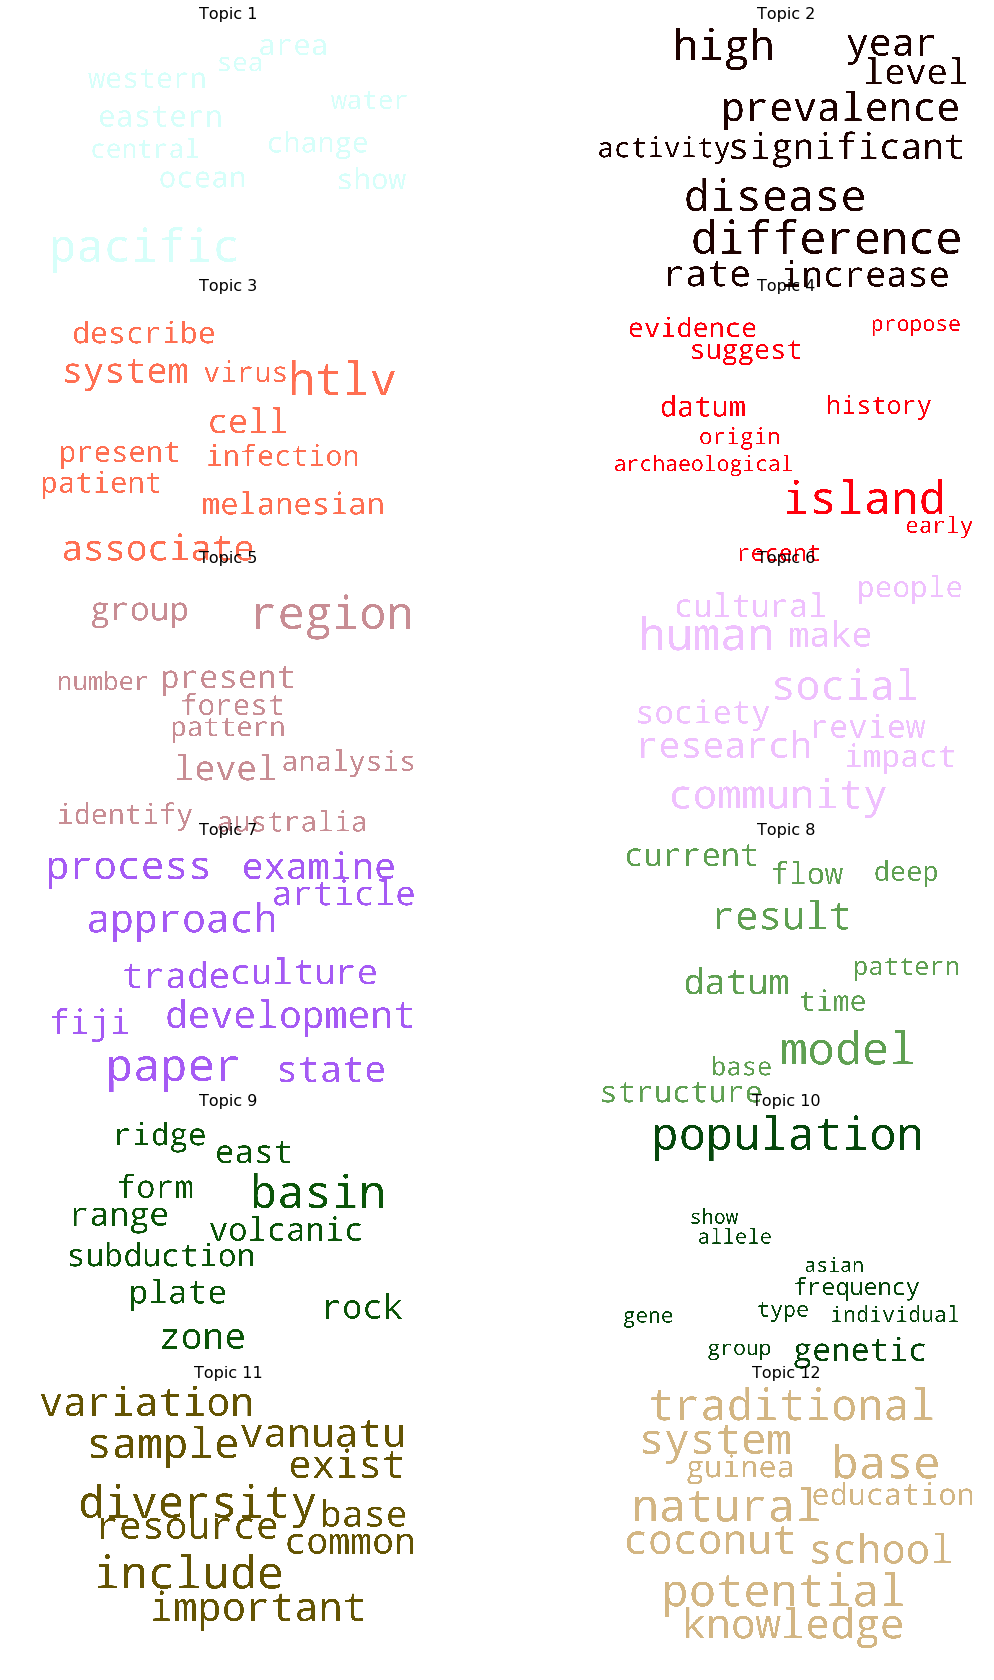

In [41]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab8',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(6, 2, figsize = (20, 30), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

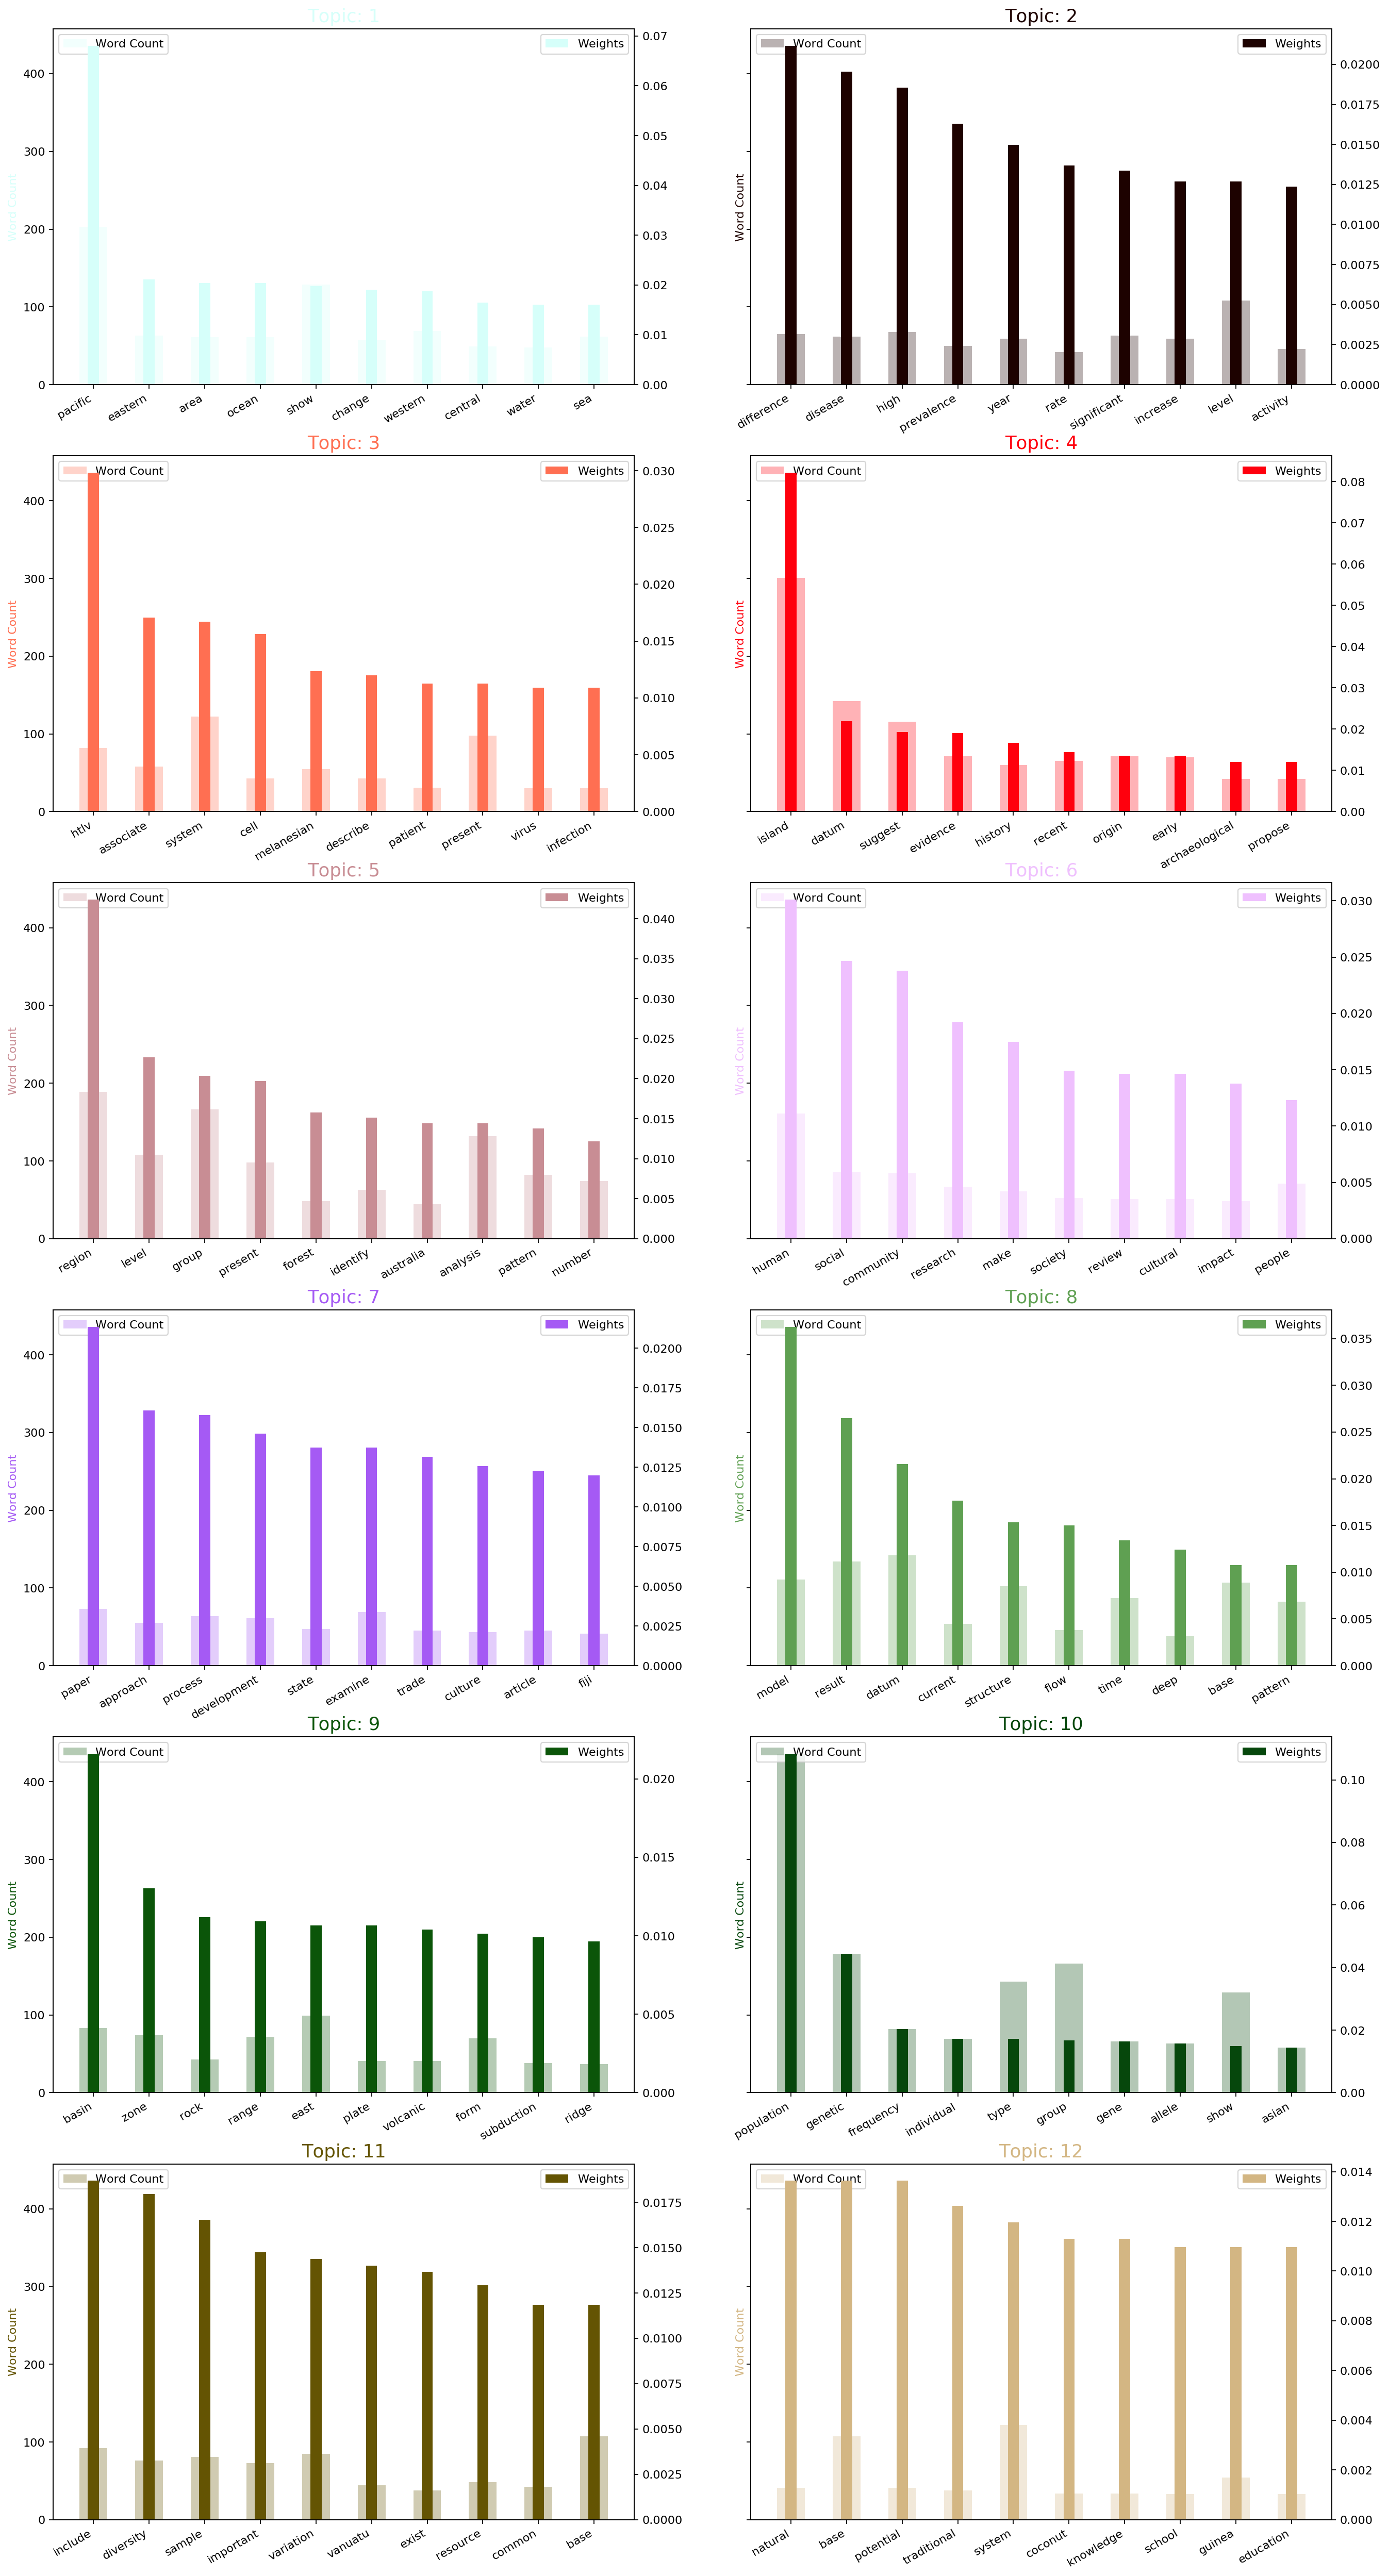

In [42]:
from collections import Counter
topics = optimal_model.show_topics(num_topics = -1, formatted=False)
data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(6, 2, figsize=(20, 40), sharey=True, dpi=160)
cols = [color for name, color in mcolors.XKCD_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
plt.savefig('IslandsCorpus12.pdf')
plt.show()